<a href="https://colab.research.google.com/github/notrandomath/Recipe-Generator-AI/blob/main/Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired by / based on: [shakespeare generator](https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb)

# Import Dependencies

In [1]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import ast

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)

Python version: 3.10.12
Tensorflow version: 2.15.0


# Import Dataset


change project folder location to google drive (source: https://robertbrucecarter.com/writing/2020/06/setting-your-working-directory-to-google-drive-in-a-colab-notebook/)

In [2]:
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/Food/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

create_and_set_working_directory(project_folder)

based on [stack overflow](https://stackoverflow.com/a/53282688)

In [3]:
df=pd.read_csv('food_recipes/RAW_recipes.csv')
df = df.head(256)
print(df)

                                                  name      id  minutes  \
0           arriba   baked winter squash mexican style  137739       55   
1                     a bit different  breakfast pizza   31490       30   
2                            all in the kitchen  chili  112140      130   
3                                   alouette  potatoes   59389       45   
4                   amish  tomato ketchup  for canning   44061      190   
..                                                 ...     ...      ...   
251                     pass me another   hot clam dip  147477       15   
252                      pasta  with shrimp   eggplant  223349       50   
253                        perfect  chocolate frosting   86768       15   
254  pink stuff     cherry pie filling  pineapple d...  197001        5   
255                            pizza pan  potato skins   60938       60   

     contributor_id   submitted  \
0             47892  2005-09-16   
1             26278  2002-06-

# Analyze Dataset

In [4]:
def convert_to_numbered_list(string_representation):
    lst = ast.literal_eval(string_representation)
    return "\n".join(lst) + '\n'
df['steps'] = df['steps'].apply(lambda x: convert_to_numbered_list(x))

In [5]:
all_steps_text = ''.join(df['steps'])
# gets length of all the steps in all recipes
print(len(all_steps_text))
# prints first steps
print(all_steps_text[:250])
# prints the unique characters in the file
vocab = sorted(set(all_steps_text.replace("\n", " \n ").split(sep=" ")))
print(f'{len(vocab)} unique words')
print(f'vocab: {vocab}')

131508
make a choice and proceed with recipe
depending on size of squash , cut into half or fourths
remove seeds
for spicy squash , drizzle olive oil or melted butter over each cut squash piece
season with mexican seasoning mix ii
for sweet squash , drizzle
2250 unique words
vocab: ['', '\n', '!', '"caramalized"', '"dress', '"dry"', '"dust"', '"high"', '"hold"in', '"low"', '"naked"', '"wet"', '&', "'bed'", "'my", '(if', ',', '-', '--', '-inch', '/', '00', '1', '1"', '1-1', '1-2', '1-quart', '10', '10"', '10-12', '10-14', '10-15', '10-inch', '100', '10minutes', '10~20', '11', '12', '12-', '12-15', '12-muffin', '13', '13"', '13-15', '13x9', '13x9-inch', '13x9x2-inch', '14-15', '15', '15-20', '15minutes', '15x10-inch', '16', '160f', '17"x10"', '175', '18-20', '180c', '1ltr', '1tbsp', '2', '2"', '2-1', '2-3', '2-4', '2-gallon', '2-inch', '2-quart', '20', '20-25', '20-30', '20-ounce', '200', '200c', '20cm', '24', '25', '25-30', '250', '2tbsp', '3', '3"', '3-4', '3-5', '3-quart', '30', '30-3

# Process Dataset

## Vectorize the Text
Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [6]:
# Map characters to their indices in vocabulary.
word2index = {word: index for index, word in enumerate(vocab)}

print('{')
for word, _ in zip(word2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(word), word2index[word]))
print('  ...\n}')

# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

# Convert chars in text to indices.
df['steps_int'] = df['steps'].apply(lambda x: [word2index[word] for word in x.replace("\n", " \n ").split(sep=" ")])
text_as_int = df['steps_int'].explode().reset_index(drop=True).tolist()

print(f'text_as_int length: {len(text_as_int)}')
print(f'({all_steps_text[:15]})->({text_as_int[:15]})')

{
  ''  :   0,
  '\n':   1,
  '!' :   2,
  '"caramalized"':   3,
  '"dress':   4,
  '"dry"':   5,
  '"dust"':   6,
  '"high"':   7,
  '"hold"in':   8,
  '"low"':   9,
  '"naked"':  10,
  '"wet"':  11,
  '&' :  12,
  "'bed'":  13,
  "'my":  14,
  '(if':  15,
  ',' :  16,
  '-' :  17,
  '--':  18,
  '-inch':  19,
  ...
}
['' '\n' '!' ... 'ziploc' 'zipperbag' 'zucchini']
text_as_int length: 27782
(make a choice a)->([1185, 171, 487, 225, 1545, 2212, 1593, 1, 665, 1356, 1788, 1342, 1876, 16, 633])


# Create training sequences

In [7]:
# # Convert the pandas DataFrame to a tf.data.Dataset
sub_text_as_int = df['steps_int'].explode().reset_index(drop=True).tolist()
# steps_list = sub_df['steps_int'].tolist()

# # Find the maximum length in the list
# max_length = max(len(x) for x in steps_list)

# # Pad the lists to the maximum length
# padded_steps_list = [x + [0] * (max_length - len(x)) for x in steps_list]

# Create a TensorFlow dataset from the padded list
# chunk_size = 32
dataset = tf.data.Dataset.from_tensor_slices(sub_text_as_int)

for char in dataset.take(5):
    print(index2char[char.numpy()])

# make sequences
sequence_length = 100
dataset = dataset.batch(sequence_length+1, drop_remainder=True)

for item in dataset.take(5):
  print(' '.join(index2char[item.numpy()]))

make
a
choice
and
proceed
make a choice and proceed with recipe 
 depending on size of squash , cut into half or fourths 
 remove seeds 
 for spicy squash , drizzle olive oil or melted butter over each cut squash piece 
 season with mexican seasoning mix ii 
 for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece 
 season with sweet mexican spice mix 
 bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin 
 be careful not
to burn the squash especially if you opt to use sugar or butter 
 if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking 
 if desired , season with salt 
  preheat oven to 425 degrees f 
 press dough into the bottom and sides of a 12 inch pizza pan 
 bake for 5 minutes until set but not browned 
 cut sausage into small pieces 
 whisk eggs and milk in a bowl until frothy 
 spoon sausage over baked crust and

In [8]:
def split_input_target(chunk):
    input_text = chunk[:-1] # input_text = chunk[:, :-1]
    target_text = chunk[1:] # target_text = chunk[:, 1:]
    return input_text, target_text

    # return input_text, target_text

dataset = dataset.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

for input_example, target_example in dataset.take(1):
    print(f'Input sequence size: {len(input_example.numpy())}')
    print(f'Input sequence size: {len(target_example.numpy())}')
    print()
    print('Input: ' + ''.join(str(index2char[i]) for i in input_example.numpy()))
    print('Target: ' + ''.join(str(index2char[i]) for i in target_example.numpy()))

for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print(f'  input: {input_idx} ({index2char[input_idx]})')
    print(f'  expected output: {target_idx} ({index2char[target_idx]})')

dataset size: 275
Input sequence size: 100
Input sequence size: 100

Input: makeachoiceandproceedwithrecipe
dependingonsizeofsquash,cutintohalforfourths
removeseeds
forspicysquash,drizzleoliveoilormeltedbutterovereachcutsquashpiece
seasonwithmexicanseasoningmixii
forsweetsquash,drizzlemeltedhoney,butter,gratedpiloncilloovereachcutsquashpiece
seasonwithsweetmexicanspicemix
bakeat350degrees,againdependingonsize,for40minutesuptoanhour,untilaforkcaneasilypiercetheskin
becareful
Target: achoiceandproceedwithrecipe
dependingonsizeofsquash,cutintohalforfourths
removeseeds
forspicysquash,drizzleoliveoilormeltedbutterovereachcutsquashpiece
seasonwithmexicanseasoningmixii
forsweetsquash,drizzlemeltedhoney,butter,gratedpiloncilloovereachcutsquashpiece
seasonwithsweetmexicanspicemix
bakeat350degrees,againdependingonsize,for40minutesuptoanhour,untilaforkcaneasilypiercetheskin
becarefulnot
Step  0
  input: 1185 (make)
  expected output: 171 (a)
Step  1
  input: 171 (a)
  expected output: 487 (choice

# Build the Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           576000    
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 2250)          2306250   
                                                                 
Total params: 8129226 (31.01 MB)
Trainable params: 8129226 (31.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


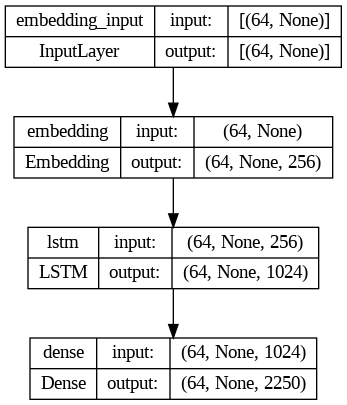

In [9]:
# Define the batch size
batch_size = 64

# Batch the dataset
dataset = dataset.batch(batch_size, drop_remainder=True)

# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

# *Test* the Model

In [10]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 2250) # (batch_size, sequence_length, vocab_size)


In [11]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-0.00125457 -0.00039627  0.00075157 ...  0.00119111 -0.00082035
 -0.00086959], shape=(2250,), dtype=float32)


# Train the model

In [12]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

Prediction shape:  (64, 100, 2250)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       7.718809


# Configure Checkpoints

In [13]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Execute the training

In [14]:
for input_data, labels in dataset.take(1):
    print("Input data shape:", input_data.shape)
    print("Labels shape:", labels.shape)

EPOCHS=40

history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Input data shape: (64, 100)
Labels shape: (64, 100)
Epoch 1/40
4/4 [==============================] - 46s 11s/step - loss: 7.4518
Epoch 2/40
4/4 [==============================] - 46s 11s/step - loss: 5.9513
Epoch 3/40
4/4 [==============================] - 40s 10s/step - loss: 5.8248
Epoch 4/40
4/4 [==============================] - 43s 11s/step - loss: 5.7657
Epoch 5/40
4/4 [==============================] - 40s 10s/step - loss: 5.7440
Epoch 6/40
4/4 [==============================] - 39s 10s/step - loss: 5.7271
Epoch 7/40
4/4 [==============================] - 39s 10s/step - loss: 5.7166
Epoch 8/40
4/4 [==============================] - 41s 10s/step - loss: 5.7048
Epoch 9/40
4/4 [==============================] - 40s 10s/step - loss: 5.6911
Epoch 10/40
4/4 [==============================] - 40s 10s/step - loss: 5.6745
Epoch 11/40
4/4 [==============================] - 39s 10s/step - loss: 5.6535
Epoch 12/40
4/4 [==============================] - 40s 10s/step - loss: 5.6259
Epoch 13/

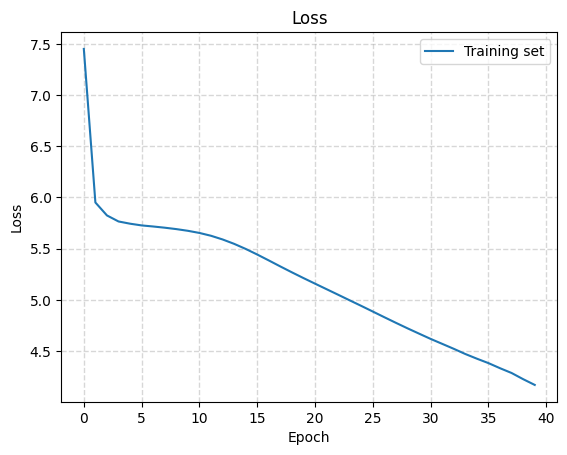

In [15]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()
render_training_history(history)

# Generate text

In [16]:
checkpoint_dir = 'tmp/checkpoints'

tf.train.latest_checkpoint(checkpoint_dir)

simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            576000    
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 2250)           2306250   
                                                                 
Total params: 8129226 (31.01 MB)
Trainable params: 8129226 (31.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_index = [word2index[word] for word in start_string.split()]
    input_indices = tf.expand_dims(input_index, 0)

    # Empty string to store our results.
    index = 1
    text_generated = []
    text_generated.append(f'{index}. {start_string}')

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        if "\n" == index2char[predicted_id]:
          text_generated.append(f'\n{index}.')
          index += 1
        else:
          text_generated.append(index2char[predicted_id])


    return (' '.join(text_generated))

# Generate the text with default temperature (1.0).
print(generate_text(model, start_string="start by"))

1. start by battered gravy: vegetarian filling and thinly if cook into cookie of and squeeze remaining pickles ! 
1. add the creamed are peanuts to each roll several meat 
2. add all on 2 cutlets mallet 
3. / sure burgers , or until chocolate of clean 
4. drain with 400 , and a 4 
5. like all the and peanuts oil and occasionally with pesto a hang combine out center 
6. slowly coat carrots , about 10 minutes or until sauce 
7. add a cream uncovered or each brown cheese makes the produced bowl , mix well 
8.  preheat oven to scramble them ingredients or until with acid-proof of water 
9. blend in a thin melt the ball the lettuce in a cake 
10. remove all pan and one at 2 simmer entire popsicle pan 
11. add ooze into approximately wooden boil until top , add to 45 sauce 
12. put well 
13. mix sugar and spread with ingredients in fork water bottles into the oven and baby kind 
14. turn all the noodles of 200 squares blended 
15. stir for the margarine 
16. spray immediately 
17. add cilant

In [ ]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')
!cp -r './text_generation_shakespeare_rnn.h5' /content/drive/MyDrive/